In [70]:
import math as math
import autograd as Agrad
#import autograd.numpy as np 
import numpy as np
import numpy.fft as fft
import scipy.optimize
import scipy.stats as st
from scipy.integrate import trapz
from scipy.integrate import simps
from photutils import find_peaks
from photutils import detect_threshold
# -- plotting --- 
import matplotlib as mpl 
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False


np.random.seed(42)

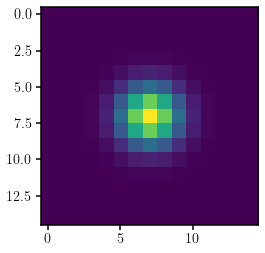

In [71]:
#create global definitions for the data

#create global definitions - this will become a main function later on
np.random.seed(42)
Ndata = 5;
n_grid = 15;
pix_1d = np.linspace(0., 1., n_grid) # pixel gridding
fdensity_true = float(Ndata)/float(n_grid**2); #number density of obj in 1d

#use very small psf and noise
sig_psf = 0.1 # psf width
sig_noise = 0.01 # noise level

#create our psf
mid = int(n_grid/2);
x,y = np.meshgrid(pix_1d,pix_1d);
psf = np.exp(-((y-pix_1d[mid])**2 + (x - pix_1d[mid])**2)/2/sig_psf**2); #keep in mind difference between x and y position and indices! Here, you are given indices, but meshgrid is in x-y coords
#fourier transform of psf
psf_k = fft.fft2(psf);
#display psf
plt.imshow(psf);

In [72]:
#create the mock data we will work on
#create coordinate grid
theta_grid = np.linspace(0., 1., n_grid) # gridding of theta (same as pixels)

#create true values - assign to grid
x_true = np.abs(np.random.rand(Ndata)) # location of sources
y_true = np.abs(np.random.rand(Ndata));
w_true = np.abs(np.random.rand(Ndata))*2 # with intensity betwen 1-2

#true grid needs to be set up with noise
w_true_grid = np.zeros((n_grid,n_grid))
for x,y, w in zip(x_true,y_true, w_true): 
    w_true_grid[np.argmin(np.abs(theta_grid - x)),np.argmin(np.abs(theta_grid - y))] = w
#now create the 'data' by convolving with psf and adding random noise
#by convolution thrm we conolve by inverse tranforming the multiplication of the fft of the data and fft of the psf

data = np.real(fft.ifft2(fft.fft2(w_true_grid)*psf_k)) + np.absolute(sig_noise* np.random.randn(n_grid,n_grid));

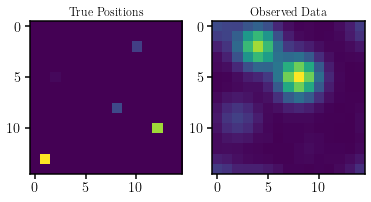

In [73]:
#display the true coordinates and observed data
fig, ax = plt.subplots(1,2)
ax[0].imshow(w_true_grid);
ax[0].set_title('True Positions')
ax[1].imshow(data);
ax[1].set_title('Observed Data')
plt.show();

Notice that the positions of the observed data do not match the true positions. This is due to the periodic boundary conditions of doing convolution, as we do not use padding to adjust.

In [74]:
#In order to minmize w.r.t. complex numbers we embed the complex nummbers into real space with twice the dimensions
#e.g. C -> 2R
#here are our helper functions for this
def real_to_complex(z):      # real vector of length 2n -> complex of length n
    return z[:len(z)//2] + 1j * z[len(z)//2:]

def complex_to_real(z):      # complex vector of length n -> real of length 2n
    return np.real(np.concatenate((np.real(z), np.imag(z))));

#our prior is a lognormal so we make helper functions
norm_mean = -5.; #mean for lognormal
norm_sig = 0.75;

#expects ws, NOT the fourier coefficients ws_k
def lognorm(ws):
    norm_mean = -5.; #mean for lognormal
    norm_sig = 0.75;
    return np.exp(-0.5*(np.log(ws) - norm_mean)**2 /norm_sig**2)/np.sqrt(2*np.pi)/norm_sig/ws;

#derivative of lognorm
def diff_lognorm(ws):
    #taken from: https://iopscience.iop.org/article/10.1088/1742-6596/1338/1/012036/pdf
    df = -1*lognorm(ws)*(1/ws - (np.log(ws)-norm_mean)/ws/norm_sig**2);
    
    return df;
    

In [75]:
#now we define our loss function (basically log likelihood)
#ws is the fourier coefficients embedded into the reals and flattened to a 1d array

def loss_like(ws_k):
    #gaussian likelihood, assumes ws_k is in complex form and 2d
    conv = np.real(fft.ifft2(ws_k*psf_k)); #convolution of ws with psf
    like_loss = 0.5 * np.sum((conv - data)**2) /sig_noise**2 #gaussian likelihood loss
    
    return like_loss;
def loss_prior(ws_k):
    #prior, assumes ws_k is in complex form and 2d
    ws = np.real(fft.ifft2(ws_k)); #need ws to calc prior (maybe I'll figure out a way to only use ws_k later)
    p1 = 0;
    p2 = 0;
    prior = lognorm(ws)*(1-fdensity_true-fdensity_true**2) + p1*fdensity_true + p2*fdensity_true**2; #full prior
    lnprior = np.log(prior); #remember we work in logspace for this
    prior_loss = np.sum(lnprior);
    
    return prior_loss;

def loss_fn(ws_k):
    ws_k = real_to_complex(ws_k); #2*reals -> complex
    ws_k = ws_k.reshape((n_grid,n_grid)); #reshape to 2d
    return loss_like(ws_k) - loss_prior(ws_k);

In [76]:
#now define gradients

def grad_like(ws_k):
    #gradient of likelihood portion of loss
    #assumes ws_k is in complex form and 2d
    conv = np.real(fft.ifft2(ws_k*psf_k)); #convolution of ws with psf
    grad = fft.ifft2(conv - data)*psf_k/sig_noise**2 #gradient
    grad_real = complex_to_real(np.conj(grad)); #embed to 2R, don't forget complex conjugate!
    
    return grad_real.flatten(); #return 1d array

def grad_prior(ws_k):
    #gradient of prior portion of loss
    #assumes ws_k is in complex form and 2d
    ws = np.real(fft.ifft2(ws_k));
    
    #prior takes the form sum ln(p(x))
    #to differentiate, we get p'(x)/|p(x)|
    #if p(x) is just a constant*lognorm, p'(x) is simply p(x)*(-1/x - (lnx - mean)/x/sig^2)
    #and p(x) cancels, leaving only the second term
    #for derivation: https://iopscience.iop.org/article/10.1088/1742-6596/1338/1/012036/pdf
    #might lose a negative here due to abs value, but it shouldn't be negative anyway
    
    #keep in mind we take the invfft of p'(x)/|p(x)|
    grad = fft.ifft2(-1/ws - (np.log(ws)-norm_mean)/ws/norm_sig**2);
    
    '''
    if p1 and p2 aren't zero, account for that here
    1) we pick up gradients from them so p'(x) changes
    2) they remain in p(x) so we don't get to cancel our lognormal nicely (even if they are constants)
    '''
    
    grad_real = complex_to_real(np.conj(grad)); #embed to 2R, don't forget complex conjugate!
    return grad_real.flatten();

#total grad_loss, assumes input is fourier coeffs embed in reals and 1d array
def grad_loss(ws_k):
    ws_k = real_to_complex(ws_k); #2*reals -> complex
    ws_k = ws_k.reshape((n_grid,n_grid)); #reshape to 2d
    
    return grad_like(ws_k) - grad_prior(ws_k);
    

In [77]:
#now define hessian

def hess_like(ws_k):
    #assumes ws_k is in complex form and 2d
    diag = (psf_k/n_grid/sig_noise)**2;
    diag_real = complex_to_real(np.conj(diag.flatten()));
    #this needs to be returned as a 2d array;
    hess = np.zeros((2*n_grid**2,2*n_grid**2)); #factor of two because of embeding from C -> 2R
    np.fill_diagonal(hess,diag_real);
    
    return hess;

def hess_prior(ws_k):
    #assumes ws_k is in complex form and 2d
    ws = np.real(fft.ifft2(ws_k))
    #we drop non-diagonal terms, only keep second derivatives
    #link in the grad_prior function has this but with a negative
    dd = np.sum((norm_sig**2 - 1 + np.log(ws) - norm_mean)/norm_sig**2/ws**2)/n_grid**2;
    #turn this into a 1d array to fill diagonal
    diag_real = np.zeros(2*n_grid**2);
    #purely real, so only fill first half 
    diag_real[0:n_grid**2] = dd;
    #this needs to be returned as a 2d array;
    hess = np.zeros((2*n_grid**2,2*n_grid**2)); #factor of two because of embeding from C -> 2R
    np.fill_diagonal(hess,diag_real);
    
    return hess;

#total hessian loss, assumes input is fourier coeffs embed in reals and 1d array
def hess_loss(ws_k):
    ws_k = real_to_complex(ws_k); #2*reals -> complex
    ws_k = ws_k.reshape((n_grid,n_grid)); #reshape to 2d
    return hess_like(ws_k) - hess_prior(ws_k);

In [78]:
#now we optimize wrt ws_k, the fourier coefficients

#create initial parameters
tt0 = np.zeros((n_grid,n_grid)) + 3; #begin with high uniform mass in each pixel
tt0_k = fft.fft2(tt0); #take fft
t_ini = complex_to_real(tt0_k.flatten()) #flatten to 1d for scipy and embed in 2R

/home/moss/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in log


Number of Iterations
90000
Final Loss
85744872.31460863


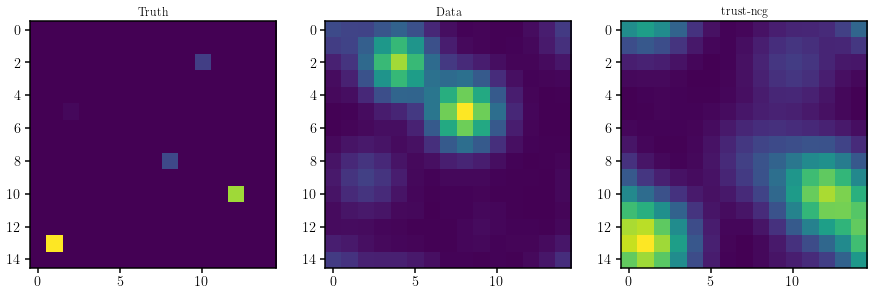

In [79]:
#optimize using scipy and our analytic gradients
res = scipy.optimize.minimize(lambda tt: loss_fn(tt),
    t_ini, # theta initial
    jac=grad_loss,
    hess = hess_loss,
    method='trust-ncg');
print('Number of Iterations');
print(res['nit']);
print('Final Loss');
print(loss_fn(res['x']));
#remember this returns the fourier coefficients embeded in the reals
w_final_k = real_to_complex(res['x']);
w_final_k = w_final_k.reshape((n_grid,n_grid)); #reshape to 2d
w_final = np.real(fft.ifft2(w_final_k));
fig, ax = plt.subplots(1,3,figsize=(15,15))
ax[0].imshow(w_true_grid);
ax[0].set_title('Truth')
ax[1].imshow(data);
ax[1].set_title('Data')
ax[2].imshow(w_final);
ax[2].set_title('trust-ncg')
plt.show();